# Labeled Faces in the Wild (LFW) experiment
The gray and normalized face images are used for face recognition and the NN classification.

In [1]:
import requests
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import tarfile
import os
import pandas as pd

# optionally download and unpack Labeled Faces in the Wild (170MB)
face_archive = 'lfw.tgz'
face_dir = 'lfw'
download_faces = False
unpack_faces = False

if download_faces:
    print ('Starting download ...')
    url = "http://vis-www.cs.umass.edu/lfw/" + face_archive
    response = requests.get(url)
    if response.status_code == 200:
        with open(face_archive, 'wb') as f:
            f.write(response.content)
            
    print ('Done.')
    
if unpack_faces:
    print ('Unpacking faces...')
    tf = tarfile.open(face_archive)
    tf.extractall()
    print ('Done.')

In [2]:
# normalize faces to this dimension
img_width = 120
img_height = 120

# Load the classifier
# Source: https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

def _extract_faces(img_path, scale_factor):
    # Read the input image in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)   
    # Normalize shades of gray
    norm_img = np.zeros(img.shape)
    norm_img = cv2.normalize(img, norm_img, 0, 255, cv2.NORM_MINMAX)
    
    # Detect faces
    faces = face_cascade.detectMultiScale(norm_img, scaleFactor=scale_factor, minSize=(80, 80), minNeighbors=4)
            
    # Extract the first face
    extracted_faces = []

    n_faces = len(faces)
    if n_faces == 0 or n_faces > 1:
        #print ('Wrong number of faces detected:', n_faces, ', path:', img_path, ', scale:', scale_factor)
        pass
        
    for (x, y, w, h) in faces:
        # take the first only
        extracted_face = norm_img[y:y+h, x:x+w]
        extracted_faces.append(extracted_face)
        #print ('w:', w, 'h:', h)
        
    return extracted_faces

def _resize_image(img):
    img = cv2.resize(img, (img_width, img_height), interpolation=cv2.INTER_CUBIC)
    return img

# adapt scale factor to extract exactly single face from the image
def extract_face(img_path):
    scale_factor = 1.05
    while scale_factor < 2.0:
        extracted_faces = _extract_faces(img_path, scale_factor)
        if (len(extracted_faces) == 1):
            # print ('Image:', img_path, 'scale:', scale_factor);
            return _resize_image(extracted_faces[0])
        scale_factor += 0.05
        
    #print ('Error, no face found:', img_path)
    return None

([], <a list of 0 Text yticklabel objects>)

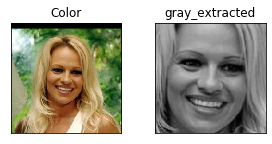

In [3]:
img_path = 'lfw\Pamela_Anderson\Pamela_Anderson_0004.jpg'
img = cv2.imread(img_path)

gray_extracted = extract_face(img_path)

fig = plt.figure(figsize=(4,4))
plt.axis("off")

plt.subplot(2, 2, 1)
plt.tight_layout()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Color')
plt.xticks([])
plt.yticks([])

plt.subplot(2, 2, 2)
plt.tight_layout()
plt.imshow(cv2.cvtColor(gray_extracted, cv2.COLOR_BGR2RGB))
plt.title('gray_extracted')
plt.xticks([])
plt.yticks([])


In [6]:
# Process data
person_list = os.listdir(path = face_dir)

all_person_extracted_faces = []
image_count = 0
errors_count = 0

print ('Processing images...')

for person in person_list:
    person_extracted_faces = []
    all_person_extracted_faces.append({'name' : person, 'faces' : person_extracted_faces})
    person_imgs = os.listdir(path = os.path.join(face_dir, person))
    for person_img in person_imgs:
        img_full_path = os.path.join(face_dir, person, person_img)
        extracted_face = extract_face(img_full_path)
        if extracted_face is not None:
            person_extracted_faces.append(extracted_face)
            image_count += 1
    if len(person_extracted_faces) == 0:
        errors_count += 1
        
print ('People found: ', len(person_list), ', images found:', image_count, ', errors:', errors_count)

Processing images...
People found:  5749 , images found: 13215 , errors: 6


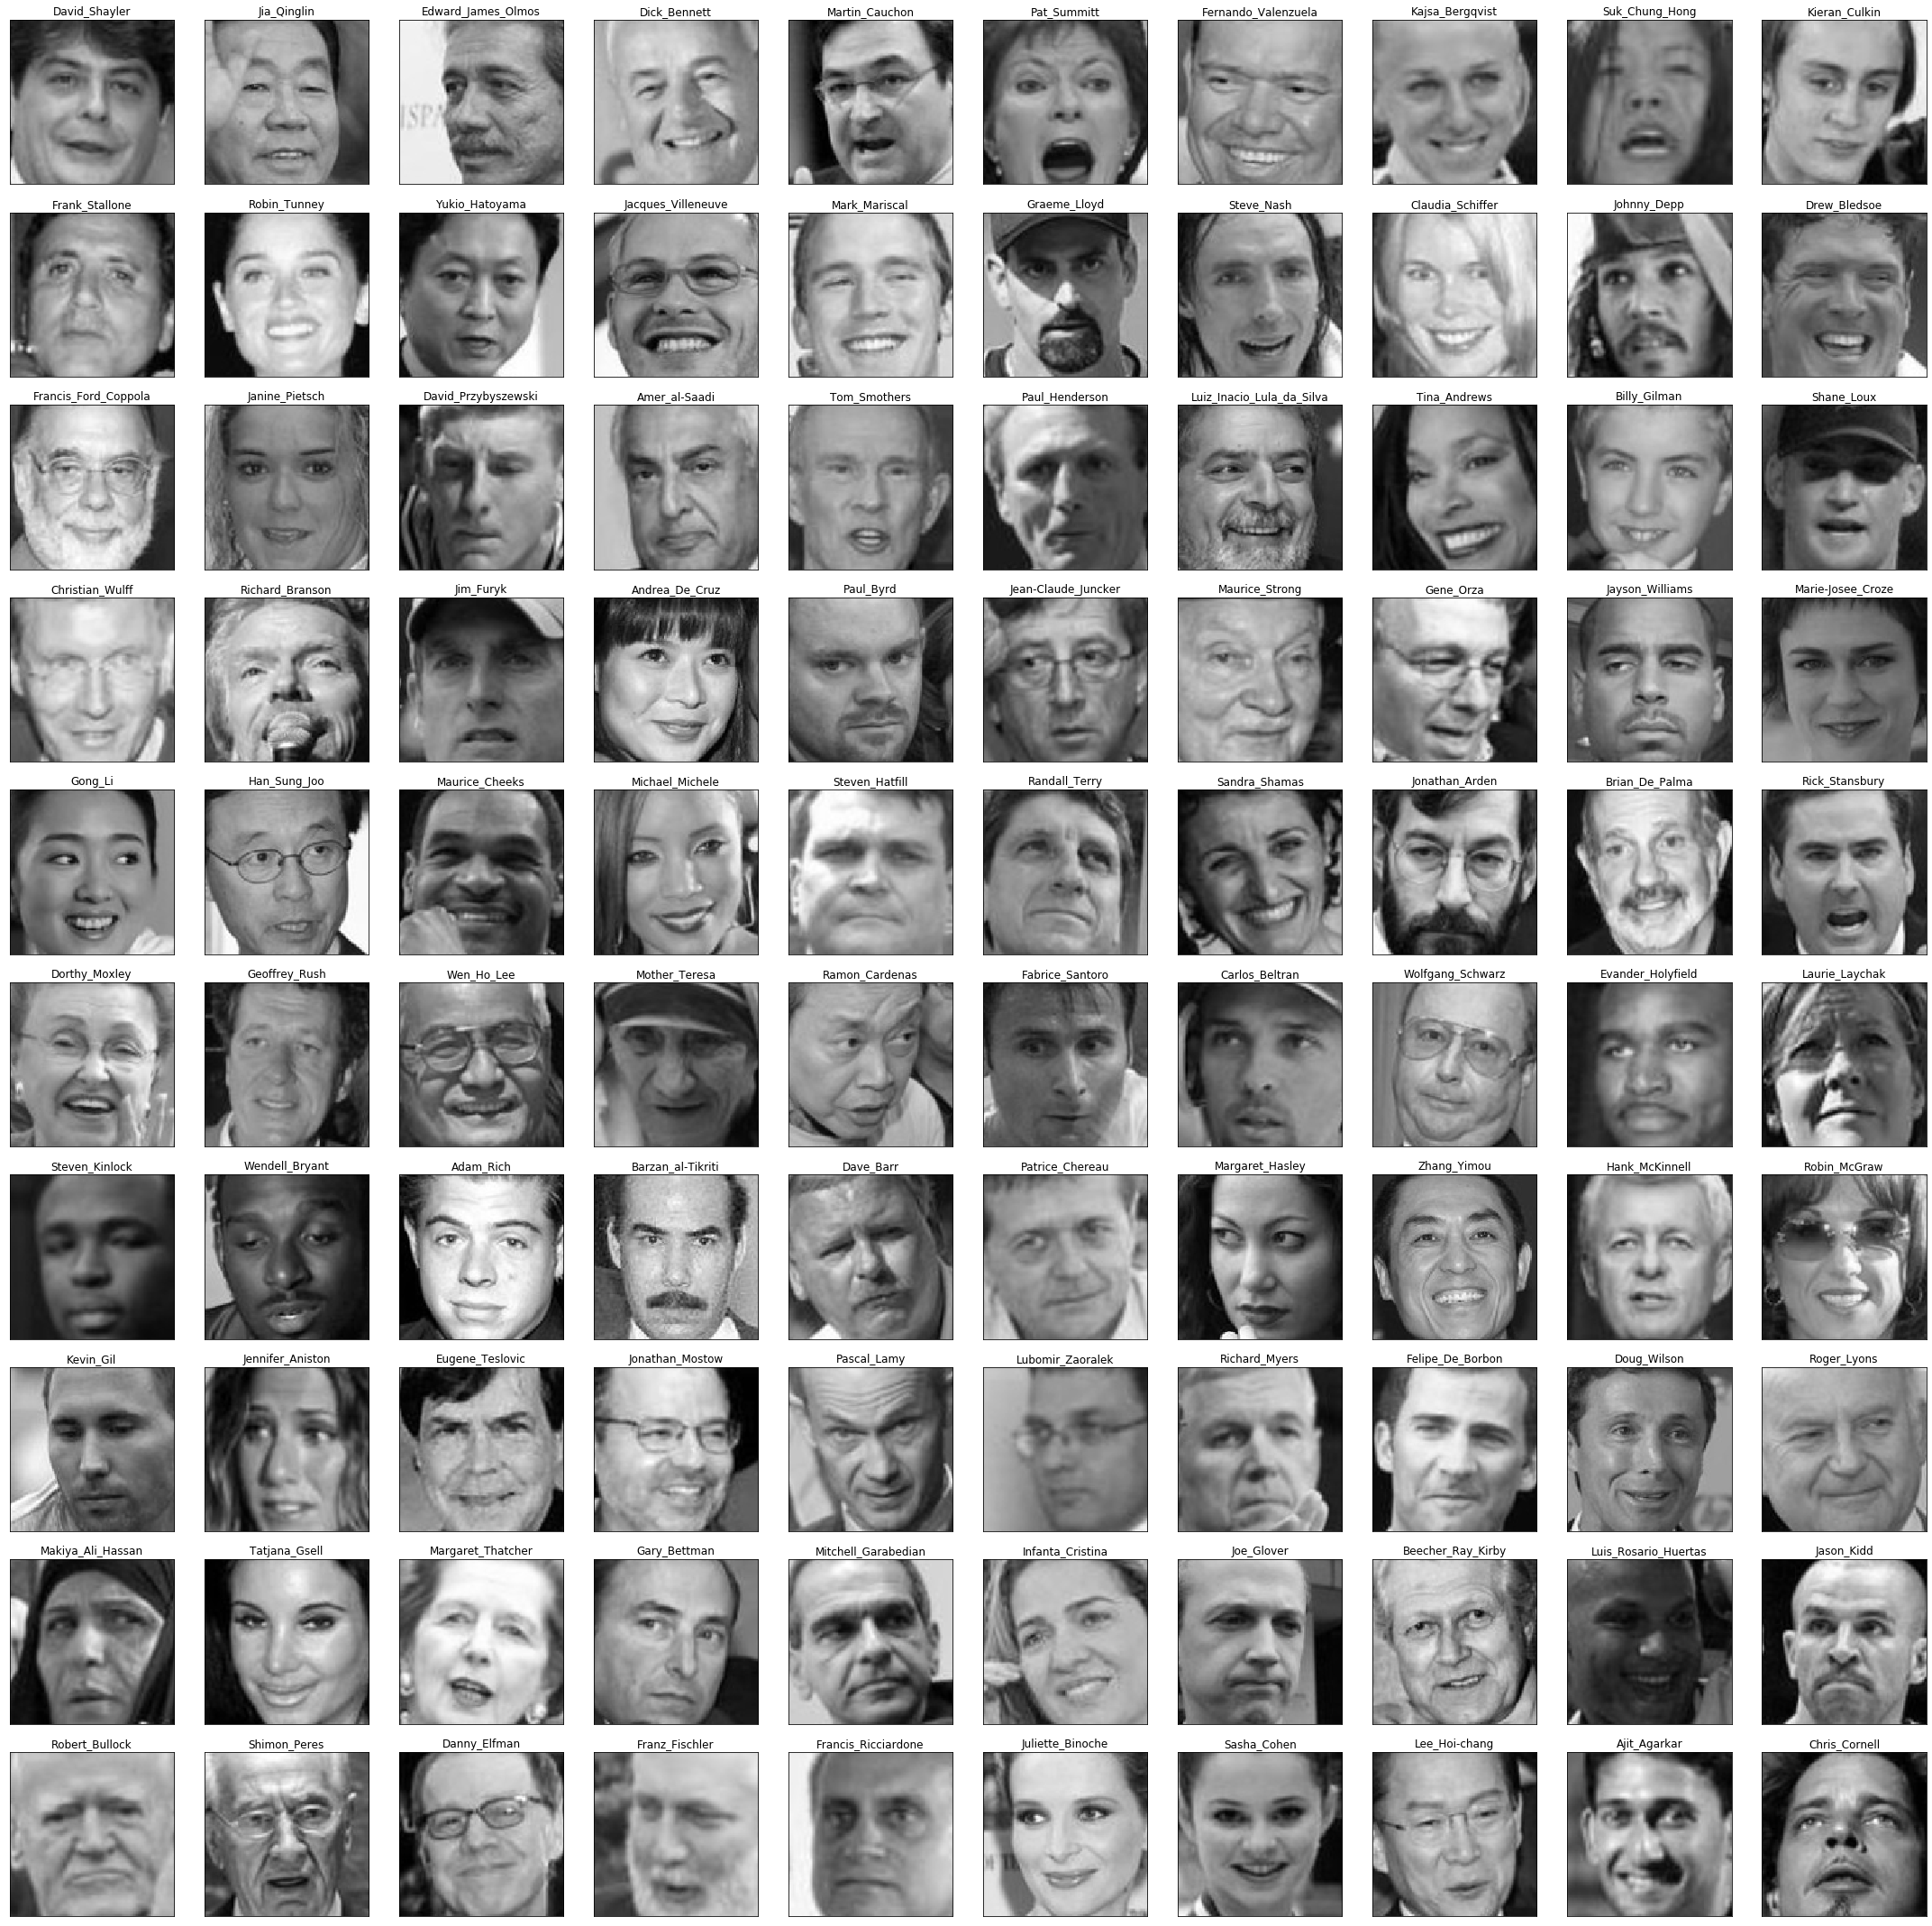

In [7]:
# show some extracted faces
import random

fig = plt.figure(figsize=(30, 30))
plt.axis("off")
for i in range(100):
    pos = random.randint(0, len(all_person_extracted_faces) - 1)
    person_with_faces = all_person_extracted_faces[pos]
    name = person_with_faces['name']
    faces = person_with_faces['faces']

    if len(faces) == 0:
        continue

    plt.subplot(10, 10, i+1)
    plt.tight_layout()
    plt.imshow(cv2.cvtColor(faces[0], cv2.COLOR_BGR2RGB), interpolation='none')
    plt.title(name)
    plt.xticks([])
    plt.yticks([])

In [8]:
# Keras (from TensorFlow) imports for building of neural network
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

In [9]:
# convert train output data into categories
num_classes = len(person_list)
num_samples = image_count

print('num_classes:', num_classes)
print('num_samples:', num_samples)

num_classes: 5749
num_samples: 13215


In [10]:
# prepare categories
Y_train = np.zeros(shape=(num_samples, num_classes), dtype=np.float32)

row_pos = 0 # image
col_pos = 0 # category = person

for person_with_faces in all_person_extracted_faces:
    faces = person_with_faces['faces']
    
    faces_count = len(faces)
    
    if faces_count > 0:
        for j in range(0, faces_count):
            Y_train[row_pos, col_pos] = 1.0
            row_pos += 1       
    
    # next person
    col_pos += 1

In [11]:
# prepare train input data
x_train = []

for person_with_faces in all_person_extracted_faces:
    faces = person_with_faces['faces']
    
    for face in faces:
        x_train.append(face)
    
X_train = np.array(x_train)
#X_train = X_train / 255.
X_train = X_train.reshape(len(x_train), img_width, img_height, 1)

print('X_train.shape:', X_train.shape)
print('Y_train.shape:', Y_train.shape)

X_train.shape: (13215, 120, 120, 1)
Y_train.shape: (13215, 5749)


In [15]:
# define CNN model for animal images classification
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=1e-4),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 118, 118, 32)      320       
_________________________________________________________________
activation_4 (Activation)    (None, 118, 118, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 59, 59, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 59, 59, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 57, 57, 64)        18496     
_________________________________________________________________
activation_5 (Activation)    (None, 57, 57, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)       

In [17]:
#model.load_weights('lfw_gray_1.h5')

In [35]:
# learn NN - tried 100 epochs
epochs = 20
batch_size = 64

history = model.fit(
    X_train,
    Y_train,
    epochs=epochs,
    batch_size=batch_size
)

Train on 13215 samples
Epoch 1/20
13215/13215 [==============================] - 342s 26ms/sample - loss: 0.4334 - accuracy: 0.8916
Epoch 2/20
13215/13215 [==============================] - 334s 25ms/sample - loss: 0.3636 - accuracy: 0.9082
Epoch 3/20
13215/13215 [==============================] - 334s 25ms/sample - loss: 0.3214 - accuracy: 0.9162
Epoch 4/20
13215/13215 [==============================] - 336s 25ms/sample - loss: 0.2672 - accuracy: 0.9283
Epoch 5/20
13215/13215 [==============================] - 332s 25ms/sample - loss: 0.2266 - accuracy: 0.9404
Epoch 6/20
13215/13215 [==============================] - 361s 27ms/sample - loss: 0.2109 - accuracy: 0.9420
Epoch 7/20
13215/13215 [==============================] - 474s 36ms/sample - loss: 0.1823 - accuracy: 0.9497
Epoch 8/20
13215/13215 [==============================] - 423s 32ms/sample - loss: 0.1597 - accuracy: 0.9549
Epoch 9/20
13215/13215 [==============================] - 397s 30ms/sample - loss: 0.1385 - accuracy: 0.9

In [36]:
model.save_weights('lfw_gray_1.h5')

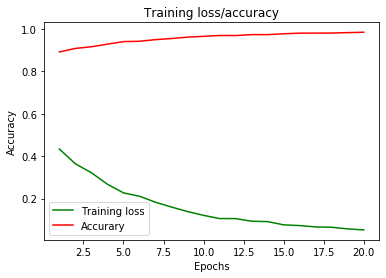

In [37]:
history_dict = history.history

loss_values = history_dict['loss']
accuracy_values = history_dict['accuracy']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'b', label='Training loss', color='green')
plt.plot(epochs, accuracy_values, 'b', label='Accurary', color='red')

plt.title('Training loss/accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [52]:
# using one of train images (images from other sources are not working is currently not demonstrative)
extracted_face = extract_face('lfw\Pamela_Anderson\Pamela_Anderson_0004.jpg')
X_test = np.array(extracted_face, dtype=np.float32)

#X_test = X_test / 255.0
X_test = X_test.reshape(img_width, img_height, 1)
X_test = np.expand_dims(X_test, axis=0)
print ('X_test:', X_test.shape)

classes = model.predict_classes(X_test, batch_size=1, verbose=1)

X_test: (1, 120, 120, 1)
1/1 [==============================] - 0s 63ms/sample


In [53]:
predicted_person = all_person_extracted_faces[classes[0]]
predicted_person_name = predicted_person['name']
predicted_person_faces = predicted_person['faces']

print('It could be:', predicted_person_name)

It could be: Pamela_Anderson


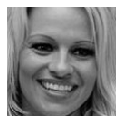

 ... could be ...


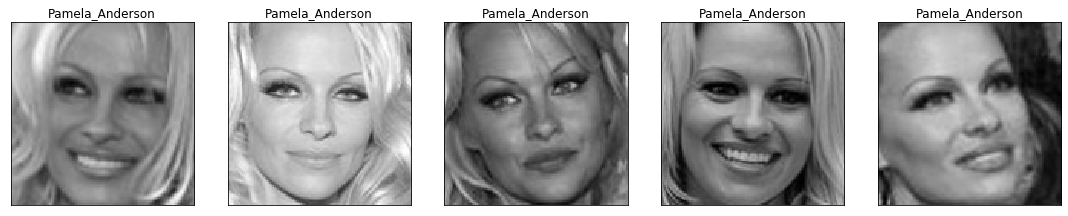

In [54]:
plt.figure(figsize=(2,2))
plt.axis("off")
plt.imshow(cv2.cvtColor(extracted_face, cv2.COLOR_BGR2RGB))
plt.show()

fig = plt.figure(figsize=(30, 30))
plt.axis("off")

print (' ... could be ...')

for i in range(len(predicted_person_faces)):
    plt.subplot(1, 10, i+1)
    plt.tight_layout()
    plt.imshow(cv2.cvtColor(predicted_person_faces[i], cv2.COLOR_BGR2RGB), interpolation='none')
    plt.title(predicted_person_name)
    plt.xticks([])
    plt.yticks([])
    if i == 9:
        break